<a href="https://colab.research.google.com/github/aaahza/Chess-Engine/blob/main/chessengine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.1 MB/s eta 0:00:00


In [3]:
import chess
import chess.engine
import random
import numpy as np
import csv
import pandas as pd

In [4]:
!chmod +x /content/drive/MyDrive/Chess_Engine/stockfish/stockfish-ubuntu-x86-64-avx2

In [5]:
piece_map = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11,
    }

In [6]:
def random_board(max_depth=200):
  board = chess.Board()
  depth = random.randrange(0, max_depth)

  for _ in range(depth):
    all_moves = list(board.legal_moves)
    random_move = random.choice(all_moves)
    board.push(random_move)
    if board.is_game_over():
      break

  return board

In [7]:
def stockfish(board, depth):
  with chess.engine.SimpleEngine.popen_uci('/content/drive/MyDrive/Chess_Engine/stockfish/stockfish-ubuntu-x86-64-avx2') as sf:
    result = sf.analyse(board, chess.engine.Limit(depth=depth))
    score = result['score'].white().score()
    return score

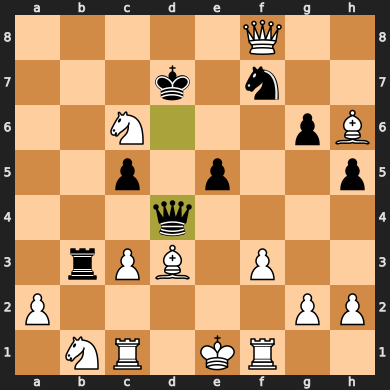

In [7]:
board = random_board()
board

In [8]:
print (stockfish(board, 10))

1054


# Creating Dataset

Configuration


In [ ]:
engine_path = "/content/drive/MyDrive/Chess_Engine/stockfish/stockfish-ubuntu-x86-64-avx2"
num_positions = 100  # Aim for a large number
output_csv = "/content/drive/MyDrive/Chess_Engine/chess_positions.csv"
evaluation_time = 0.5  # Time per evaluation in seconds

Generating Random Positions

In [14]:
def generate_random_positions(n):
    positions = []
    for _ in range(n):
        board = chess.Board()
        for _ in range(random.randint(10, 50)):  # Random number of moves
            if board.is_game_over():
                break
            legal_moves = list(board.legal_moves)
            board.push(random.choice(legal_moves))
        positions.append(board.fen())
    return positions

Evaluate Positions

In [ ]:
def evaluate_positions(positions, engine_path):
    evaluations = []
    with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
        for fen in positions:
            board = chess.Board(fen)
            info = engine.analyse(board, chess.engine.Limit(time=evaluation_time))
            score = info["score"].relative.score(mate_score=10000)
            evaluations.append((fen, score))
    return evaluations

Save to CSV

In [ ]:
def save_to_csv(data, filename):
    with open(filename, mode='a', newline='') as file:
        writer = csv.writer(file)
        # writer.writerow(["FEN", "Evaluation"])
        for row in data:
            writer.writerow(row)

Main


In [ ]:
positions = []

for i in range(1000):
  positions.extend(generate_random_positions(num_positions - len(positions)))
  evaluated_positions = evaluate_positions(positions, engine_path)
  save_to_csv(evaluated_positions, output_csv)
  print(f"Save {i + 1}: Done")

Save 1: Done
Save 2: Done
Save 3: Done
Save 4: Done
Save 5: Done
Save 6: Done
Save 7: Done
Save 8: Done
Save 9: Done
Save 10: Done
Save 11: Done
Save 12: Done
Save 13: Done
Save 14: Done
Save 15: Done
Save 16: Done
Save 17: Done
Save 18: Done
Save 19: Done
Save 20: Done
Save 21: Done
Save 22: Done
Save 23: Done
Save 24: Done
Save 25: Done
Save 26: Done
Save 27: Done
Save 28: Done
Save 29: Done
Save 30: Done
Save 31: Done
Save 32: Done
Save 33: Done
Save 34: Done
Save 35: Done
Save 36: Done
Save 37: Done
Save 38: Done
Save 39: Done
Save 40: Done
Save 41: Done
Save 42: Done
Save 43: Done
Save 44: Done
Save 45: Done
Save 46: Done
Save 47: Done
Save 48: Done
Save 49: Done
Save 50: Done
Save 51: Done
Save 52: Done
Save 53: Done
Save 54: Done
Save 55: Done
Save 56: Done
Save 57: Done
Save 58: Done
Save 59: Done
Save 60: Done
Save 61: Done
Save 62: Done
Save 63: Done
Save 64: Done
Save 65: Done
Save 66: Done
Save 67: Done
Save 68: Done
Save 69: Done
Save 70: Done
Save 71: Done
Save 72: Done
S

In [8]:
def fen_to_matrix(fen):

    matrix = np.zeros((14, 8, 8), dtype=int)

    board_config = fen.split()[0]

    row, col = 0, 0
    for char in board_config:
        if char.isdigit():
            col += int(char)
        elif char == '/':
            row += 1
            col = 0
        else:
            piece_idx = piece_map[char]
            matrix[piece_idx, row, col] = 1
            if char.isupper():
                matrix[12, row, col] = 1
            else:
                matrix[13, row, col] = 1
            col += 1

    return matrix

In [ ]:
fen_to_matrix(generate_random_positions(1)[0])

# Model

In [9]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.callbacks as callbacks

In [24]:
def build_model(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  x = board3d
  for _ in range(conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding="same", activation="relu")(x)

  x = layers.Flatten()(x)
  x = layers.Dense(64, activation="relu")(x)
  x = layers.Dense(1, activation="sigmoid")(x)

  model = models.Model(inputs=board3d, outputs=x)
  model.compile(optimizer='adam', loss='mean_squared_error')

  return model

# Residual Model

In [23]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding="same")(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding="same")(board3d)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding="same")(board3d)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation("relu")(x)

  x = layers.Flatten()(x)
  x = layers.Dense(1, activation="sigmoid")(x)

  model = models.Model(inputs=board3d, outputs=x)
  model.compile(optimizer='adam', loss='mean_squared_error')

  return model

# Training

In [13]:
def get_dataset(csv_path):
    df = pd.read_csv(csv_path)

    fen_matrices = np.array([fen_to_matrix(fen) for fen in df['FEN']])

    evaluations = df['Evaluation'].values

    return fen_matrices, evaluations

In [14]:
x_train, y_train = get_dataset("/content/drive/MyDrive/Chess_Engine/chess_positions.csv")
print(x_train.shape)
print(y_train.shape)

(103607, 14, 8, 8)
(103607,)


In [25]:
modelConv2D = build_model(32, 4)
# modelConv2D.summary()

In [ ]:
modelConv2D.fit(x_train, y_train,
                epochs=1000, batch_size=32,
                verbose=1, validation_split=0.1,
                callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                           callbacks.EarlyStopping(monitor='loss', patience=15)])

modelConv2D.save("/content/drive/MyDrive/Chess_Engine/model_conv2d.h5")

In [ ]:
modelResidual = build_model_residual(32, 4)
modelResidual.summary()

In [ ]:
# modelResidual.compile(optimizer='adam', loss='mean_squared_error')
modelResidual.summary()

In [ ]:
modelResidual.fit(x_train, y_train,
                epochs=1000, batch_size=1024,
                verbose=1, validation_split=0.1,
                callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                           callbacks.EarlyStopping(monitor='loss', patience=15)])

modelResidual.save("/content/drive/MyDrive/Chess_Engine/model_Residual.h5")

AI

In [12]:
modelConv2D = models.load_model("/content/drive/MyDrive/Chess_Engine/model_conv2d.h5")

In [26]:
def minimax_eval(board):
  board3d = fen_to_matrix(board.fen())
  board3d = np.expand_dims(board3d, axis=0)
  return modelConv2D.predict(board3d)[0]

In [27]:
def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)

  if maximizing_player:
    max_eval = -np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break

    return max_eval
  else:
    min_eval = np.inf
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break

    return min_eval

In [28]:
def get_ai_move(board, depth):
  max_move = None
  max_eval = -np.inf
  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, -np.inf, np.inf, False)
    board.pop()
    if eval > max_eval:
      max_move = move
      max_eval = eval
  return max_move

In [30]:
board = chess.Board()

with chess.engine.SimpleEngine.popen_uci('/content/drive/MyDrive/Chess_Engine/stockfish/stockfish-ubuntu-x86-64-avx2') as engine:
  while True:
    move = get_ai_move(board, 1)
    board.push(move)
    print(f'\n{board}')
    if board.is_game_over():
      break

    move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
    board.push(move)
    print(f'\n{board}')
    if board.is_game_over():
      break

1/1 [==============================] - 0s 19ms/step

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . N
P P P P P P P P
R N B Q K B . R

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . . . . .
. . . . . . . N
P P P P P P P P
R N B Q K B . R
1/1 [==============================] - 0s 26ms/step

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . N .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B . R

r n b q k b n r
p p p . . p p p
. . . . . . . .
. . . p p . N .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B . R
1/1 [==============================] - 0s 20ms/step

r n b q k b n r
p p p . . p p N
. . . . . . . .
. . . p p . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B . R

r n b q k b n .
p p p . . p p r
. . . . . . . .
. . . p p . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B . R
1/1 [==============================] - 0s 20ms/step

r n b q k b n .
p